# Excluding "minorities" during training
What happens if an ML system is trained with data that exclude minorities, but it ends up being used extensively by a minority? A system trained on data that has historically excluded women (easy example: medical data) is very likely still being used by women as they make up basically half of the Earth's population.

In [55]:
from trecs.models import ContentFiltering, PopularityRecommender, SocialFiltering
from trecs.components import Users, PredictedUserProfiles
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from utils import create_profiles, calc_group_preferences
from custom_metrics import MajorityRecommendationShare, MajoritySharePopularItems
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

### Training data
Look at a rec sys trained with data where Group A is the majority and Group B is the minority. Compositions can vary (in 5% intervals):
- Group A: 100%, Group B: 0%
- Group A: 95%, Group B: 5%
- Group A: 90%, Group B: 10%
- Group A: 85%, Group B: 15%
- ...
- Group A: 55%, Group B: 45%
- Group A: 50%, Group B: 50% (baseline)

### "Test" data
The system is then used by a balanced audience of users.
- Group A: 50%, Group B: 50%
- We could also look at a majority of Group B users.

## Train
We start with 80-20 split for both users and items. Users have a strong preference (`group_strength=1`) towards items created for them.

In [49]:
# 1000 users, 10000 items
# We test with 800 group A, 200 group B
total_users = 1000
num_group_a = 800 # so group B has 200 users
num_attrs = 11

# 8000 items for Group A members
# 2000 items for Group B members
total_items = 10000
num_items_a = 8000 # so group B created no item

# Note that group_strength = 1
# that is, each group has a strong preference towards items created for them
train_user_profiles, item_profiles = create_profiles(
    total_users=total_users, 
    total_items=total_items, 
    dynamic_creators=False,
    num_majority_users=num_group_a, 
    num_majority_items=num_items_a, 
    group_strength=1, 
    num_attrs=num_attrs
)
calc_group_preferences(user_profiles, item_profiles, num_group_a, num_items_a)

Percentage of items generated by Group A: 0.8
Members of Group A prefer items from group A 92.25% of the time.
Members of Group B prefer items from group A 8.13% of the time.


In [50]:
p = PopularityRecommender(
    actual_item_representation=item_profiles, 
    actual_user_representation=Users(
        actual_user_profiles=train_user_profiles, 
        num_users=total_users
    )
)
p.add_metrics(MajorityRecommendationShare(9), MajoritySharePopularItems(total_items, 9))
# Train with majority group
p.startup_and_train(timesteps=100)

100%|██████████| 100/100 [00:06<00:00, 15.32it/s]


## Test
Switch users to a balanced group of 50-50. Items stay the way they are (80-20). Users now have a weak preference towards items created for them (`group_strength=0.6`). 

In [51]:
# Switch users to balanced maj/min group
num_group_a_test = 500

# Note group_strength=0.6
test_user_profiles, _ = create_profiles(
    total_users=total_users, 
    total_items=total_items, 
    dynamic_creators=False,
    num_majority_users=num_group_a_test, 
    num_majority_items=num_items_a, 
    group_strength=0.6, 
    num_attrs=num_attrs
)
test_users = Users(actual_user_profiles=test_user_profiles, num_users=total_users)
test_users.compute_user_scores(item_attributes=p.items)

Percentage of items generated by Group A: 0.8


In [52]:
p.users = test_users
p.run(timesteps=100, train_between_steps=True)

100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Now we plot the dominance of the majority group's items. After training, there's a jump at 100% of items recommended to be for the majority group.

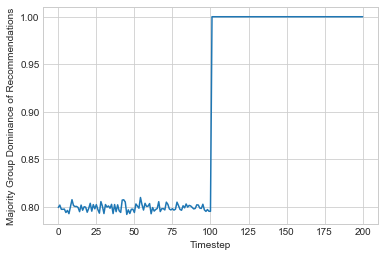

In [56]:
plt.plot(p.get_measurements()['majority_dominance'][1:])
plt.xlabel("Timestep")
plt.ylabel("Majority Group Dominance of Recommendations")
plt.show()

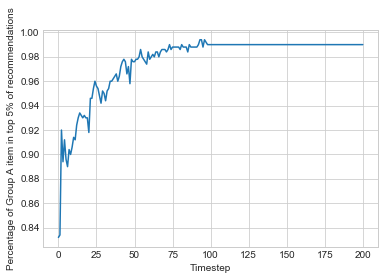

In [58]:
plt.plot(p.get_measurements()['majority_share_most_popular'][1:])
plt.xlabel("Timestep")
plt.ylabel("Percentage of Group A item in top 5% of recommendations")
plt.show()

Given that the items recommended were created for a majority group, it'd be interesting to see some metrics about the utility that the minory group gets out of these items. In other words, are these recommendations good for the minority group? Does the minority group benefit of these recommendations as much as the majority group?